In [1]:
from __future__ import absolute_import
from __future__ import print_function

import copy
import pandas as pd
from collections import defaultdict
import numpy as np
import tensorflow.compat.v1 as tf
#import tensorflow as tf
from tqdm import tqdm
from six.moves import xrange

from cleverhans.utils import other_classes
from cleverhans.utils_tf import batch_eval, model_argmax
from cleverhans.attacks_tf import (jacobian_graph, jacobian,
                                   apply_perturbations, saliency_map)
import keras.backend as K
from keras.models import load_model
from tensorflow.keras.datasets import mnist
from keras import utils
import os
from sklearn.model_selection import train_test_split
import pickle
from keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import csv

C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\attacks_tf.py:55: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn(


In [2]:
def fgsm(x, predictions, eps, clip_min=None, clip_max=None, y=None):
    # Compute loss
    if y is None:
        # In this case, use model predictions as ground truth
        y = tf.to_float(tf.equal(predictions,tf.reduce_max(predictions, 1, keepdims=True)))
    y = y / tf.reduce_sum(y, 1, keepdims=True)
    logits, = predictions.op.inputs
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

    # Define gradient of loss wrt input
    grad, = tf.gradients(loss, x)

    # Take sign of gradient
    signed_grad = tf.sign(grad)

    # Multiply by constant epsilon
    scaled_signed_grad = eps * signed_grad

    # Add perturbation to original example to obtain adversarial example
    adv_x = tf.stop_gradient(x + scaled_signed_grad)

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) and (clip_max is not None):
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    return adv_x

In [3]:
def fast_gradient_sign_method(sess, model, X, Y, eps, clip_min=None,clip_max=None, batch_size=256):
    # Define TF placeholders for the input and output
    x = tf.compat.v1.placeholder(tf.float32, shape=(None,) + X.shape[1:])
    y = tf.compat.v1.placeholder(tf.float32, shape=(None,) + Y.shape[1:])
    adv_x = fgsm(x, model(x), eps=eps,clip_min=clip_min,clip_max=clip_max, y=y)
    X_adv, = batch_eval(sess, [x, y], [adv_x],[X, Y], feed={K.learning_phase(): 0}, args={'batch_size': batch_size})
    return X_adv

In [4]:
def craft_fgsm(sess, model, X, Y, batch_size,eps):
    attack='fgsm'
    print('Crafting fgsm adversarial samples...')
    X_adv = fast_gradient_sign_method(sess, model, X, Y,eps=eps, clip_min=CLIP_MIN,clip_max=CLIP_MAX,
                                          batch_size=batch_size)
    _, acc = model.evaluate(X_adv, Y, batch_size=batch_size, verbose=0)
    print("Model accuracy on the adversarial test set: %0.2f%%" % (100 * acc))
    np.save(os.path.join(PATH_DATA, 'Adv_%s_eps_%f.npy' % (attack,eps)), X_adv)
    l2_diff = np.linalg.norm(X_adv.reshape((len(X), -1))-X.reshape((len(X), -1)),axis=1).mean()
    print("Average L-2 perturbation size of the %s attack: %f" %(attack, l2_diff))
    return l2_diff,acc

In [5]:
def basic_iterative_method(sess, model, X, Y, eps, eps_iter, nb_iter=50,
                           clip_min=None, clip_max=None, batch_size=256):
    # Define TF placeholders for the input and output
    x = tf.compat.v1.placeholder(tf.float32, shape=(None,)+X.shape[1:])
    y = tf.compat.v1.placeholder(tf.float32, shape=(None,)+Y.shape[1:])
    # results will hold the adversarial inputs at each iteration of BIM;
    # thus it will have shape (nb_iter, n_samples, n_rows, n_cols, n_channels)
    results = np.zeros((nb_iter, X.shape[0],) + X.shape[1:])
    # Initialize adversarial samples as the original samples, set upper and
    # lower bounds
    X_adv = X
    X_min = X_adv - eps
    X_max = X_adv + eps
    print('Running BIM iterations...')
    # "its" is a dictionary that keeps track of the iteration at which each
    # sample becomes misclassified. The default value will be (nb_iter-1), the
    # very last iteration.
    def f(val):
        return lambda: val
    its = defaultdict(f(nb_iter-1))
    # Out keeps track of which samples have already been misclassified
    out = set()
    for i in tqdm(range(nb_iter)):
        adv_x = fgsm(x, model(x), eps=eps_iter,clip_min=clip_min, clip_max=clip_max, y=y)
        X_adv, = batch_eval(sess, [x, y], [adv_x],[X_adv, Y], feed={K.learning_phase(): 0},args={'batch_size': batch_size}
        )
        X_adv = np.maximum(np.minimum(X_adv, X_max), X_min)
        results[i] = X_adv
        # check misclassifieds
        #predictions = model.predict_classes(X_adv, batch_size=512, verbose=0)
        predictions = np.argmax(model.predict(X_adv, batch_size=512, verbose=0),axis=1)
        misclassifieds = np.where(predictions != Y.argmax(axis=1))[0]
        for elt in misclassifieds:
            if elt not in out:
                its[elt] = i
                out.add(elt)

    return its, results

In [6]:
def craft_bim(sess, model, X, Y, batch_size,eps):
    attack='bim'
    print('Crafting bim adversarial samples...')
    its, results = basic_iterative_method(sess, model, X, Y, eps=eps,eps_iter=eps_iter, clip_min=CLIP_MIN,
            clip_max=CLIP_MAX, batch_size=batch_size)
    X_adv = np.asarray([results[its[i], i] for i in range(len(Y))]) #v1
    #X_adv = results[-1] #v2       
    _, acc = model.evaluate(X_adv, Y, batch_size=batch_size, verbose=0)
    print("Model accuracy on the adversarial test set: %0.2f%%" % (100 * acc))
    np.save(os.path.join(PATH_DATA, 'Adv_%s_eps_%f.npy' % (attack,eps)), X_adv)
    l2_diff = np.linalg.norm(X_adv.reshape((len(X), -1))-X.reshape((len(X), -1)),axis=1).mean()
    print("Average L-2 perturbation size of the %s attack: %f" %(attack, l2_diff))
    return l2_diff,acc

In [7]:
def get_model(num_classes,softmax=True):
    # MNIST model: 0, 2, 7, 10
    layers = [
            Conv2D(64, (3, 3), padding='valid', input_shape=(28, 28, 1)),  # 0
            Activation('relu'),  # 1
            BatchNormalization(), # 2
            Conv2D(64, (3, 3)),  # 3
            Activation('relu'),  # 4
            BatchNormalization(), # 5
            MaxPooling2D(pool_size=(2, 2)),  # 6
            Dropout(0.5),  # 7
            Flatten(),  # 8
            Dense(128),  # 9            
            Activation('relu'),  # 10
            BatchNormalization(), # 11
            Dropout(0.5),  # 12
            Dense(num_classes),  # 13
        ]
    model = Sequential()
    for layer in layers:
        model.add(layer)
    if softmax:
        model.add(Activation('softmax'))

    return model

In [8]:
def get_data(x_train,y_train,x_val,y_val,x_test,y_test,num_classes):
    """
    images in [-0.5, 0.5] (instead of [0, 1]) which suits C&W attack and generally gives better performance
    """
    # reshape to (n_samples, 28, 28, 1)
    X_train = x_train.reshape(-1, 28, 28, 1)
    X_val = x_val.reshape(-1, 28, 28, 1)
    X_test = x_test.reshape(-1, 28, 28, 1)        
    # cast pixels to floats, normalize to [0, 1] range
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')
    X_train = (X_train/255.0) - (1.0 - CLIP_MAX)
    X_val = (X_val/255.0) - (1.0 - CLIP_MAX)
    X_test = (X_test/255.0) - (1.0 - CLIP_MAX)

    # one-hot-encode the labels
    Y_train = utils.to_categorical(y_train, num_classes)
    Y_val = utils.to_categorical(y_val, num_classes)
    Y_test = utils.to_categorical(y_test, num_classes)

    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)
    print("X_test:", X_test.shape)
    print("Y_test", Y_test.shape)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [9]:
########### MNIST
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

########## Toy Data
## Data Process

filename = '../dataSet/BigDataset/dataset_IM_1B.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])
    
num_class = int(len(data_tuples)/1000)

data = []
for i in range(len(data_tuples)):
    data.append(data_tuples[i][0])
    
data_x=np.array(data)
data_y=np.array(class_labels)


print('Number of images:', len(data_tuples))
print('Number of classes: ', num_class)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)


Number of images: 6000
Number of classes:  6
data_x: (6000, 28, 28)
data_y: (6000,)


In [68]:
# Random split
# x_train, x_val, y_train, y_val = train_test_split(data_x, data_y,test_size=0.2, shuffle = True, random_state = 8)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,test_size=0.25, shuffle = True, random_state = 8)

# print('x_train:', x_train.shape)
# print('x_val:', x_val.shape)
# print('x_test:', x_test.shape)
# print('y_train:', y_train.shape)
# print('y_train:', y_val.shape)
# print('y_test:', y_test.shape)

x_train: (3600, 28, 28)
x_val: (1200, 28, 28)
x_test: (1200, 28, 28)
y_train: (3600,)
y_train: (1200,)
y_test: (1200,)


In [10]:
## Manual split
# Train data
N = int(data_x.shape[0] * 0.6)
num_class = 6
num_measure=1000
interval = int(N / num_class)
k = 0
x_train = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_train = np.zeros(N)

for i in range(0, N, interval):
    x_train[i:i + interval] = data_x[k:k + interval]
    y_train[i:i + interval] = data_y[k:k + interval]
    k += num_measure

## Validation data
N = int(data_x.shape[0] * 0.2)
k = interval
interval = int(N / num_class)

x_val = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_val = np.zeros(N)

for i in range(0, N, interval):
    x_val[i:i + interval] = data_x[k:k + interval]
    y_val[i:i + interval] = data_y[k:k + interval]
    k += num_measure

## Test data
N = int(data_x.shape[0] * 0.2)
k = num_measure - interval
interval = int(N / num_class)
x_test = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_test = np.zeros(N)

for i in range(0, N, interval):
    x_test[i:i + interval] = data_x[k:k + interval]
    y_test[i:i + interval] = data_y[k:k + interval]
    k += num_measure

    
    
print('x_train:', x_train.shape)
print('x_val:', x_val.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)
print('y_test:', y_test.shape)

x_train: (3600, 28, 28)
x_val: (1200, 28, 28)
x_test: (1200, 28, 28)
y_train: (3600,)
y_val: (1200,)
y_test: (1200,)


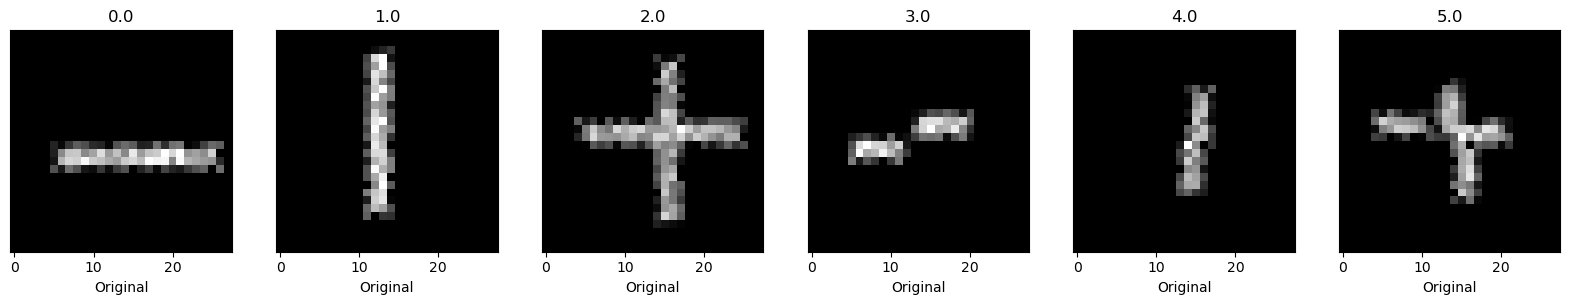

In [11]:
n = 6 
start=0
end=1200
interval=200
plt.figure(figsize=(20, 4))

k=1
for i in range(start,end,interval):
    # Display original
    ax = plt.subplot(1, n, k)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(y_test[i])
    ax.set_xlabel('Original')
    k += 1

plt.show()

In [12]:
def train(batch_size=128, epochs=50):
    X_train, Y_train, X_val, Y_val, _, _ = get_data(x_train, y_train, x_val, y_val, x_test, y_test, num_classes)
    model = get_model(num_classes=num_classes,softmax=True)
    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    model.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1,validation_data=(X_val, Y_val))
    model.save('Toy_data/model.h5')

In [13]:
def gen_adv_instance(attack,eps):
    print('Attack: %s' % (attack))
    # Create TF session, set it as Keras backend
    sess = tf.compat.v1.Session()
    tf.compat.v1.keras.backend.set_session(sess)
    model = load_model(model_file)
    _, _, _, _, X_test, Y_test = get_data(x_train, y_train, x_val, y_val, x_test, y_test,num_classes)
    _, acc = model.evaluate(X_test, Y_test, batch_size=batch_size,verbose=0)
    print("Accuracy on the test set: %0.2f%%" % (100*acc))
    if attack=='fgsm':
        l2_diff,acc=craft_fgsm(sess, model, X_test, Y_test,batch_size=batch_size, eps=eps)
        print('Adversarial samples crafted and saved to %s ' % PATH_DATA)
        sess.close()
        
    elif attack=='bim':
        l2_diff,acc=craft_bim(sess, model, X_test, Y_test,batch_size=batch_size, eps=eps)
        print('Adversarial samples crafted and saved to %s ' % PATH_DATA)
        sess.close()
    return l2_diff,acc

In [14]:
# FGSM/BIM parameters that were chosen
eps_iter=0.010
CLIP_MIN = 0
CLIP_MAX = 1
PATH_DATA = "Toy_data/"
num_classes=6
batch_size=100
model_file='Toy_data/model.h5'

In [15]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data(x_train, y_train, x_val, y_val, x_test, y_test,num_classes)

X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)


In [123]:
train(batch_size=128, epochs=100)

X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Epoch 1/100
29/29 [==============================] - 8s 242ms/step - loss: 3.0591 - accuracy: 0.1383 - val_loss: 1.7922 - val_accuracy: 0.1667
Epoch 2/100
29/29 [==============================] - 7s 233ms/step - loss: 2.8319 - accuracy: 0.1706 - val_loss: 1.7934 - val_accuracy: 0.1667
Epoch 3/100
29/29 [==============================] - 7s 234ms/step - loss: 2.6698 - accuracy: 0.1947 - val_loss: 1.7956 - val_accuracy: 0.1667
Epoch 4/100
29/29 [==============================] - 7s 232ms/step - loss: 2.5574 - accuracy: 0.2158 - val_loss: 1.7988 - val_accuracy: 0.1667
Epoch 5/100
29/29 [==============================] - 7s 245ms/step - loss: 2.3872 - accuracy: 0.2358 - val_loss: 1.8034 - val_accuracy: 0.1667
Epoch 6/100
29/29 [==============================] - 7s 250ms/step - loss: 2.3060 - accuracy: 0.2603 - val_loss: 1.8095 - val_accuracy: 0.1667
Epoch 7/100

29/29 [==============================] - 8s 259ms/step - loss: 0.7442 - accuracy: 0.7156 - val_loss: 0.2780 - val_accuracy: 0.9692
Epoch 58/100
29/29 [==============================] - 7s 258ms/step - loss: 0.7253 - accuracy: 0.7250 - val_loss: 0.2674 - val_accuracy: 0.9717
Epoch 59/100
29/29 [==============================] - 7s 259ms/step - loss: 0.7249 - accuracy: 0.7264 - val_loss: 0.2616 - val_accuracy: 0.9733
Epoch 60/100
29/29 [==============================] - 8s 263ms/step - loss: 0.7317 - accuracy: 0.7192 - val_loss: 0.2574 - val_accuracy: 0.9733
Epoch 61/100
29/29 [==============================] - 8s 260ms/step - loss: 0.7233 - accuracy: 0.7250 - val_loss: 0.2521 - val_accuracy: 0.9733
Epoch 62/100
29/29 [==============================] - 8s 263ms/step - loss: 0.6689 - accuracy: 0.7422 - val_loss: 0.2444 - val_accuracy: 0.9783
Epoch 63/100
29/29 [==============================] - 7s 257ms/step - loss: 0.6815 - accuracy: 0.7475 - val_loss: 0.2365 - val_accuracy: 0.9808
Epoch

C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
tf.compat.v1.disable_eager_execution()

In [126]:
result_fgsm=[]

for i in range(1,13,1):
    eps=i/10000
    l2_diff,acc=gen_adv_instance(attack='fgsm', eps=eps)
    result_fgsm.append([eps, l2_diff, acc])

# save results    
fields = ['Epsilon', 'Noise', 'Accuracy'] 
with open('FGSM.csv', 'w', newline='') as f:    
    # using csv.writer method from CSV package
    write = csv.writer(f)  
    write.writerow(fields)
    write.writerows(result_fgsm)    


Attack: fgsm
Instructions for updating:
Colocations handled automatically by placer.
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)


C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on the test set: 99.33%
Crafting fgsm adversarial samples...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\utils_tf.py:321: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\evaluation.py:497: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn(


Model accuracy on the adversarial test set: 90.00%
Average L-2 perturbation size of the fgsm attack: 0.002049
Adversarial samples crafted and saved to Toy_data/ 
Attack: fgsm
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting fgsm adversarial samples...
Model accuracy on the adversarial test set: 66.58%
Average L-2 perturbation size of the fgsm attack: 0.004093
Adversarial samples crafted and saved to Toy_data/ 
Attack: fgsm
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting fgsm adversarial samples...
Model accuracy on the adversarial test set: 50.92%
Average L-2 perturbation size of the fgsm attack: 0.006134
Adversarial samples crafted and saved to Toy_data/ 
Attack: fgsm
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_

In [19]:
Result_fgsm=pd.read_csv('FGSM.csv')
Result_fgsm

,Epsilon,Noise,Accuracy
0,0.0001,0.002049,0.900000
1,0.0002,0.004093,0.665833
2,0.0003,0.006134,0.509167
3,0.0004,0.008171,0.435000
4,0.0005,0.010203,0.337500
5,0.0006,0.012231,0.238333
6,0.0007,0.014256,0.161667
7,0.0008,0.016275,0.130000
8,0.0009,0.018290,0.123333
9,0.0010,0.020301,0.128333


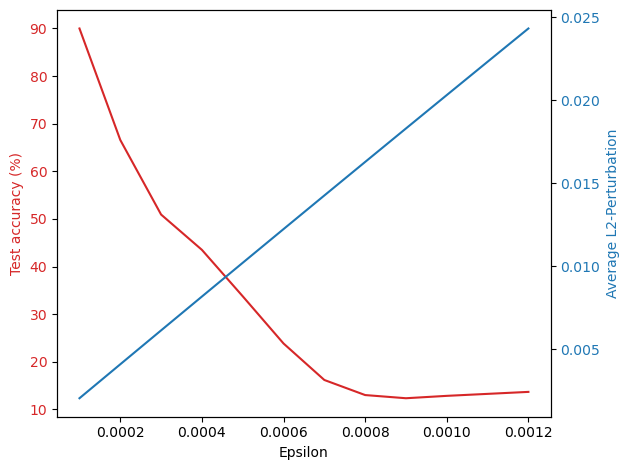

In [50]:
# plt.plot(Result_fgsm['Epsilon'],Result_fgsm['Accuracy'])
# plt.xlabel('Epsilon')
# plt.ylabel('Test accuracy')
# plt.title('Crafted Adversarial Example (FGSM)')




fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Test accuracy (%)', color=color)
ax1.plot(Result_fgsm['Epsilon'], Result_fgsm['Accuracy']*100, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average L2-Perturbation', color=color)  # we already handled the x-label with ax1
ax2.plot(Result_fgsm['Epsilon'], Result_fgsm['Noise'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('FGSM_analysis.png',dpi=600)
plt.show()


In [107]:
attack='fgsm'
eps=0.0007
adv_data_fgsm=np.load(os.path.join(PATH_DATA, 'Adv_%s_eps_%f.npy' % (attack,eps)))

In [108]:
model = load_model(model_file)
adv_data_fgsm_pred=model.predict(adv_data_fgsm)
adv_data_fgsm_pred_classes=np.argmax(adv_data_fgsm_pred,axis=1)
print(adv_data_fgsm_pred_classes)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_921:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_914:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_907:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_900:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_893:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_886:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_879:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_872:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_865:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_858:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_851:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_844:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_837:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_830:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_823:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_816:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_809:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_802:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_795:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_788:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_781:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_774:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_767:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_760:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_753:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_746:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loca

RuntimeError: Attempted to use a closed Session.

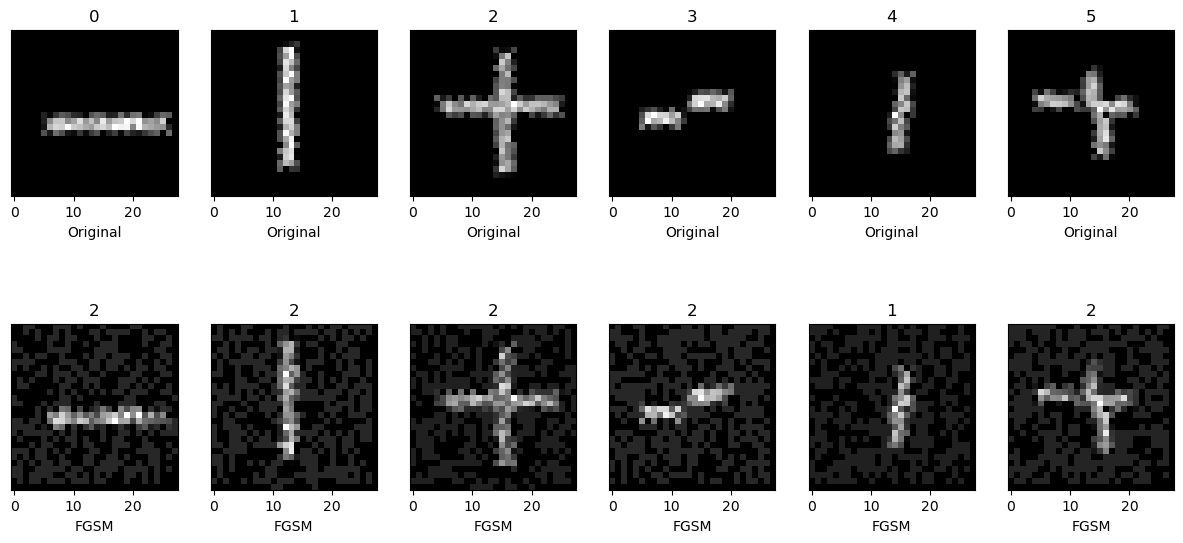

In [109]:

n = 6 
start=0
end=1200
interval=200
plt.figure(figsize=(15,7))

k=1
for i in range(start,end,interval):
    # Display original
    ax = plt.subplot(2, n, k)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(int(y_test[i]))
    ax.set_xlabel('Original')
    
    # Adversarial FGSM
    ax = plt.subplot(2, n, k+n)
    plt.imshow(adv_data_fgsm[i].reshape(28, 28))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(adv_data_fgsm_pred_classes[i])
    ax.set_xlabel('FGSM')
    k += 1


plt.savefig('FGSM.png',dpi=600)
plt.show()



In [77]:
l2_diff,acc=gen_adv_instance(attack='bim', eps=0.003) 

Attack: bim
Instructions for updating:
Colocations handled automatically by placer.
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)


C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\utils_tf.py:321: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\evaluation.py:497: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:49<00:00,  3.39s/it]


Model accuracy on the adversarial test set: 5.33%
Average L-2 perturbation size of the bim attack: 0.059764
Adversarial samples crafted and saved to Toy_data/ 


In [110]:
l2_diff,acc=gen_adv_instance(attack='bim', eps=0.0003) 

Attack: bim
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:56<00:00,  9.53s/it]


Model accuracy on the adversarial test set: 27.33%
Average L-2 perturbation size of the bim attack: 0.006262
Adversarial samples crafted and saved to Toy_data/ 


In [17]:
# Stopped after 7 th iteration. eps=0.000600
result_bim=[]

for i in range(5,13,2):
    eps=i/10000
    l2_diff,acc=gen_adv_instance(attack='bim', eps=eps)
    result_bim.append([eps, l2_diff, acc])


Attack: bim
Instructions for updating:
Colocations handled automatically by placer.
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)


C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\utils_tf.py:321: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\cleverhans\evaluation.py:497: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn(
C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:17<00:00,  3.95s/it]


Model accuracy on the adversarial test set: 4.17%
Average L-2 perturbation size of the bim attack: 0.010318
Adversarial samples crafted and saved to Toy_data/ 
Attack: bim
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:58<00:00,  8.37s/it]


Model accuracy on the adversarial test set: 1.50%
Average L-2 perturbation size of the bim attack: 0.014300
Adversarial samples crafted and saved to Toy_data/ 
Attack: bim
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [23:47<00:00, 28.55s/it]


Model accuracy on the adversarial test set: 0.25%
Average L-2 perturbation size of the bim attack: 0.018308
Adversarial samples crafted and saved to Toy_data/ 
Attack: bim
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [40:09<00:00, 48.18s/it]


Model accuracy on the adversarial test set: 0.33%
Average L-2 perturbation size of the bim attack: 0.022331
Adversarial samples crafted and saved to Toy_data/ 


In [18]:
l2_diff,acc=gen_adv_instance(attack='bim', eps=0.0001) 

Attack: bim
X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_val: (1200, 28, 28, 1)
Y_val: (1200, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)
Accuracy on the test set: 99.33%
Crafting bim adversarial samples...
Running BIM iterations...


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:09:25<00:00, 83.31s/it]


Model accuracy on the adversarial test set: 85.25%
Average L-2 perturbation size of the bim attack: 0.002103
Adversarial samples crafted and saved to Toy_data/ 


In [121]:
# save results    
fields = ['Epsilon', 'Noise', 'Accuracy'] 
with open('BIM.csv', 'w', newline='') as f:    
    # using csv.writer method from CSV package
    write = csv.writer(f)  
    write.writerow(fields)
    write.writerows(result_fgsm)

In [53]:
Result_bim=pd.read_csv('BIM.csv')
Result_bim

,Epsilon,Noise,Accuracy
0,0.0001,0.002147,88.17
1,0.0002,0.004321,50.67
2,0.0003,0.006418,13.50
3,0.0004,0.008404,8.08
4,0.0005,0.010420,3.75
5,0.0006,0.012487,1.67


In [111]:
attack='bim'
eps=0.0003
adv_data_bim=np.load(os.path.join(PATH_DATA, 'Adv_%s_eps_%0.4f00.npy' % (attack,eps)))

In [112]:
adv_data_bim.shape

(1200, 28, 28, 1)

In [113]:
model = load_model(model_file)
adv_data_bim_pred=model.predict(adv_data_bim)
adv_data_bim_pred_classes=np.argmax(adv_data_bim_pred,axis=1)
print(adv_data_bim_pred_classes)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_1143:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loc

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_1136:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loc

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.SymbolicTensor'>):
<tf.Tensor 'VarIsInitializedOp_1129:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 4340, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 786, in get_session
    _initialize_variables(session)  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1252, in _initialize_variables
    is_initialized = session.run(  File "C:\Users\roydipta\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend.py", line 1253, in <listcomp>
    [tf.compat.v1.is_variable_initialized(v) for v in candidate_vars]  File "C:\Users\roydipta\AppData\Loc

RuntimeError: Attempted to use a closed Session.

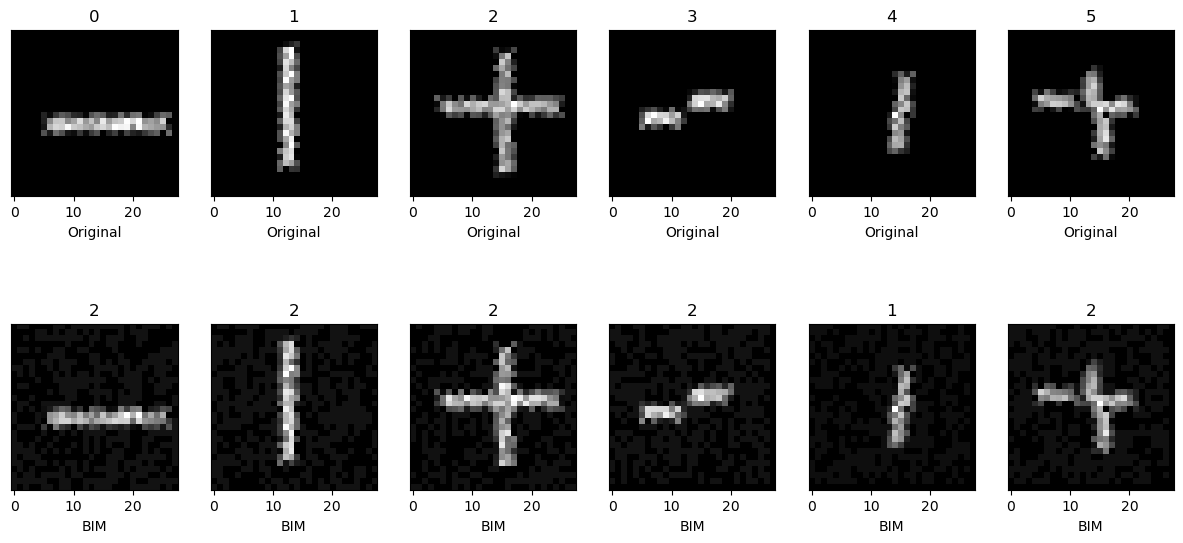

In [114]:
n = 6 
start=0
end=1200
interval=200
plt.figure(figsize=(15,7))

k=1
for i in range(start,end,interval):
    # Display original
    ax = plt.subplot(2, n, k)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(int(y_test[i]))
    ax.set_xlabel('Original')
    
    # Adversarial FGSM
    ax = plt.subplot(2, n, k+n)
    plt.imshow(adv_data_bim[i].reshape(28, 28))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(adv_data_bim_pred_classes[i])
    ax.set_xlabel('BIM')
    k += 1


plt.savefig('BIM.png',dpi=600)
plt.show()

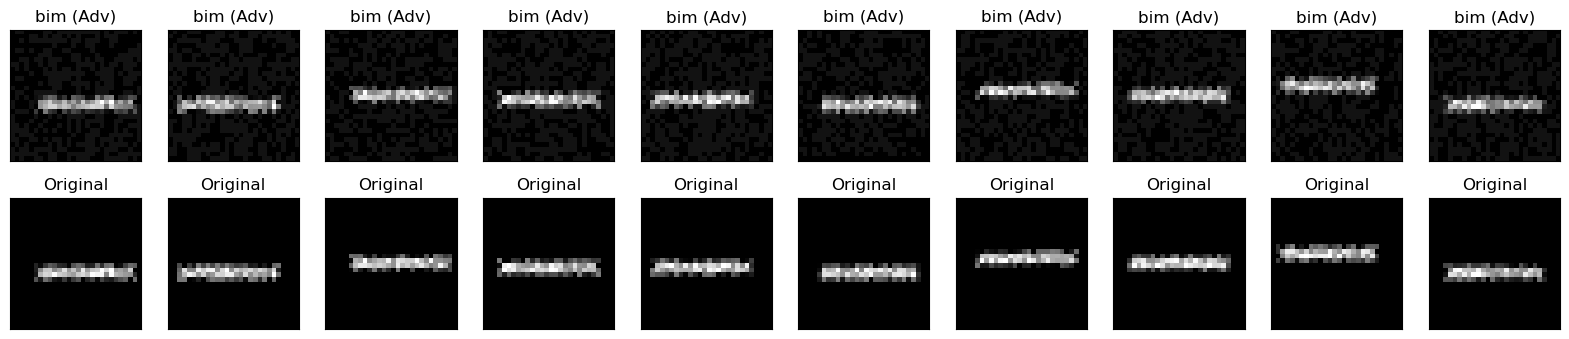

In [115]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    # Display adversarial example
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(adv_data_bim[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('bim (Adv)')

    
plt.show()

In [39]:
import numpy, scipy.io
scipy.io.savemat('..\dataSet\BigDataset\dataset_IM_1B.mat', mdict={'data_x': data_x})